In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 30, 6
import seaborn as sb
sb.set()
from datetime import datetime as dt
import mplfinance as fplt

# import pandas_datareader as pdr

In [2]:
"""import pandas_ta as pa

pa.rsi(df.Clos, length=16)"""

'import pandas_ta as pa\n\npa.rsi(df.Clos, length=16)'

In [3]:
df = pd.read_csv('resources/dataset/2018-2022_1min.csv')

df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df.set_index('open_time', inplace=True, drop=False)
print(df.shape)

timeframe = 1 # minutes
df = df.groupby(pd.Grouper(freq=f'{timeframe}min', origin='start', label='right')).agg({'close_price':'last',
                                                                                        'high_price':'max',
                                                                                        'low_price':'min',
                                                                                        'open_price':'first',
                                                                                        'taker_buy_base_asset_volume':'sum',
                                                                                        'open_time':'first',
                                                                                        'volume':'sum',
                                                                                        'trades':'sum'})

df.head(5)

(2586873, 12)


,close_price,high_price,low_price,open_price,taker_buy_base_asset_volume,open_time,volume,trades
open_time,,,,,,,,
2018-01-01 00:01:00,13707.92,13715.65,13681.00,13715.65,2.002554,2018-01-01 00:00:00,2.844266,32
2018-01-01 00:02:00,13694.92,13707.91,13666.11,13707.91,0.264134,2018-01-01 00:01:00,2.113138,29
2018-01-01 00:03:00,13680.00,13694.94,13680.00,13682.00,0.753332,2018-01-01 00:02:00,1.346411,46
2018-01-01 00:04:00,13645.99,13679.98,13601.00,13679.98,5.507146,2018-01-01 00:03:00,11.589417,137
2018-01-01 00:05:00,13600.00,13646.00,13576.28,13645.98,9.739792,2018-01-01 00:04:00,15.724566,191


In [4]:
btc_return = df['close_price']
btc_return = round(np.log(btc_return).diff() * 100, 2)
btc_return.dropna(inplace=True)
btc_return[:5]

open_time
2018-01-01 00:02:00   -0.09
2018-01-01 00:03:00   -0.11
2018-01-01 00:04:00   -0.25
2018-01-01 00:05:00   -0.34
2018-01-01 00:06:00   -0.24
Name: close_price, dtype: float64

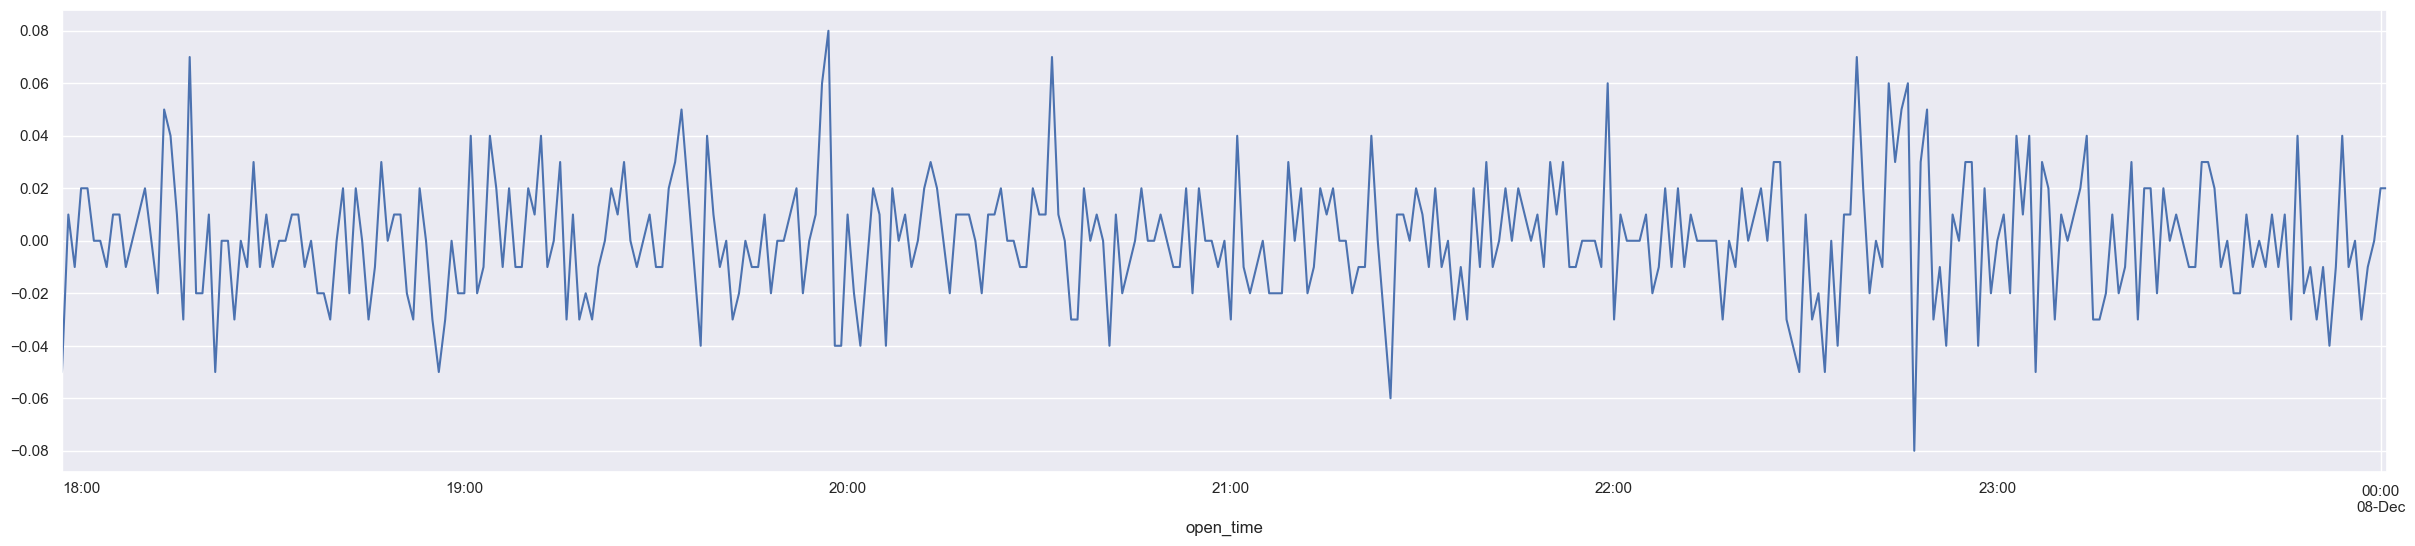

In [5]:
(btc_return[-365:]).plot();

In [6]:
from scipy import stats
from scipy.stats import norm

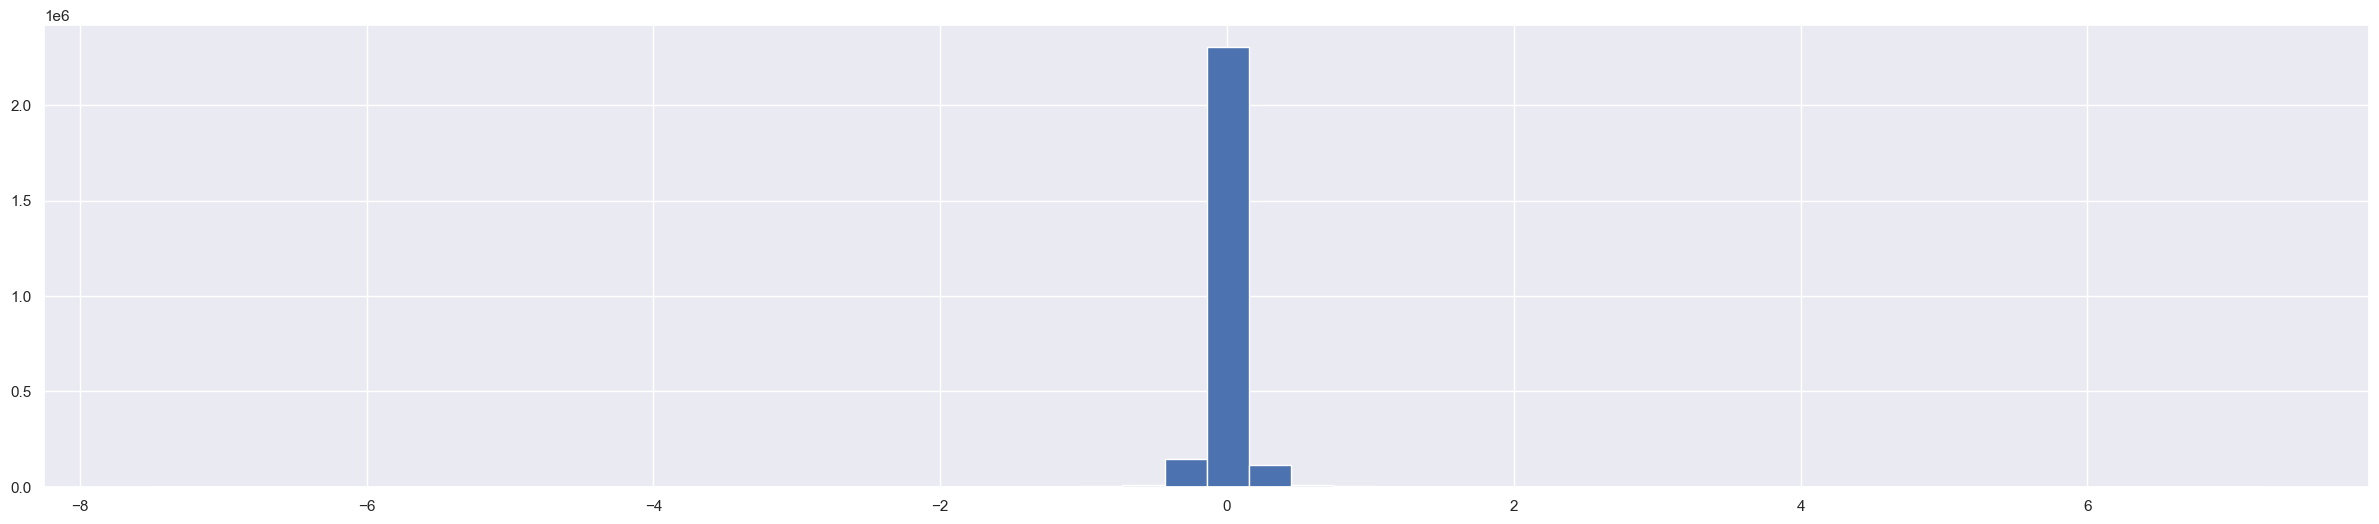

In [7]:
n, minmax, mean, var, skew, kurt = stats.describe(btc_return)
mini, maxi = minmax
std = var ** 0.5

x = norm.rvs(mean, std, n)

plt.hist(btc_return, bins=50);

In [8]:
# Reject the null

x_test = stats.kurtosistest(x)
btc_test = stats.kurtosistest(btc_return)
print(f'\t{"Test statistic":20}{"p-values":<15}')
print(' ' * 4,'-' * 30)
print(f'x:{x_test[0]:>17.2f}{x_test[1]:16.4f}')
print(f'BTC:{btc_test[0]:>15.2f}{btc_test[1]:16.4f}')

	Test statistic      p-values       
     ------------------------------
x:             1.87          0.0612
BTC:        1006.53          0.0000


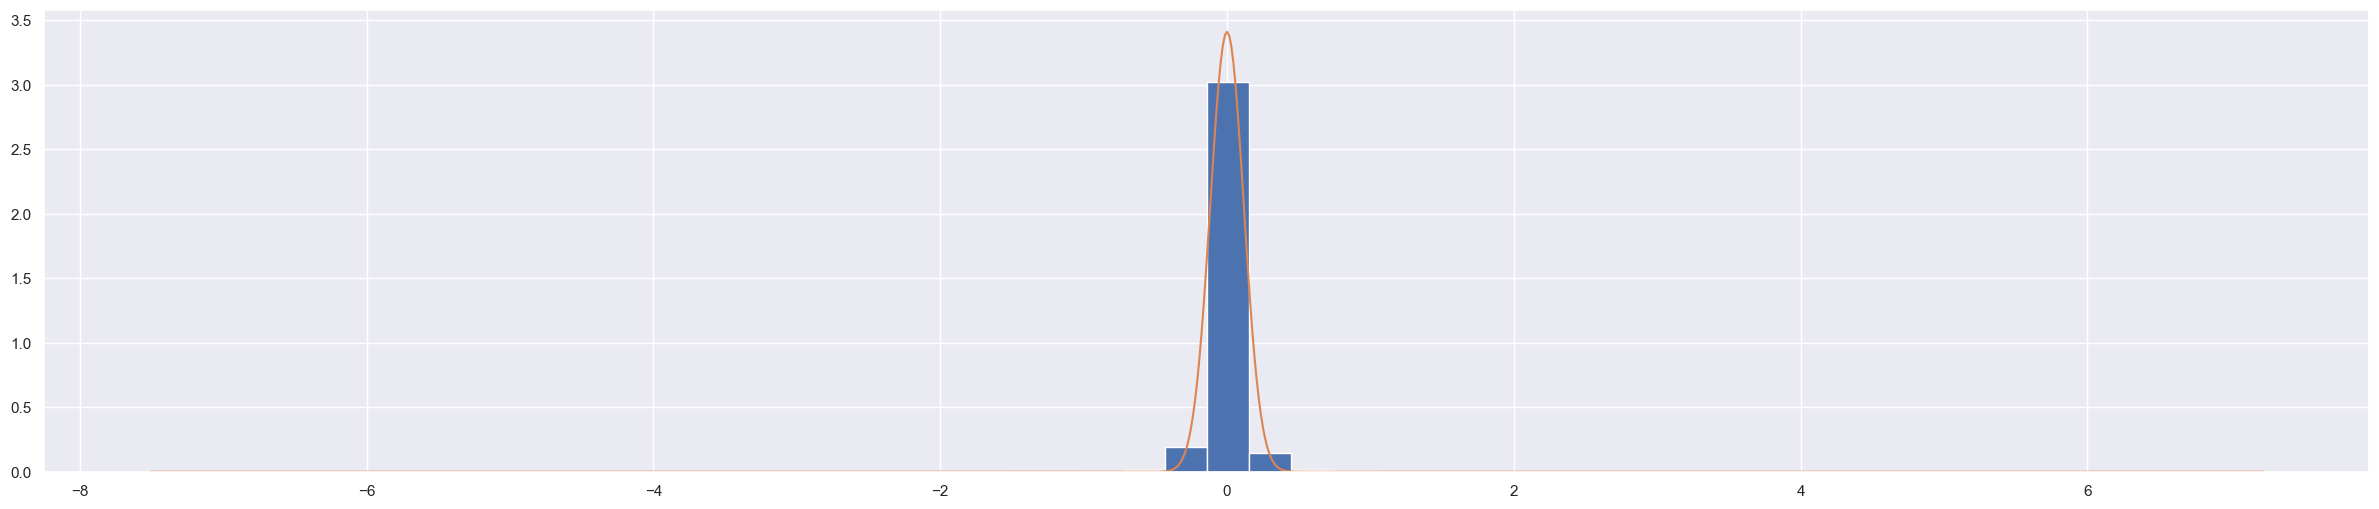

In [9]:
plt.hist(btc_return, bins=50, edgecolor='w', density=True)
overlay = np.linspace(mini, maxi, 1000)
plt.plot(overlay, norm.pdf(overlay, mean, std));

# Can not be described as normally distribuided

In [10]:
stats.ttest_1samp(btc_return.sample(252), 0, alternative='two-sided')

Ttest_1sampResult(statistic=0.8887468301425927, pvalue=0.3749900812093073)

In [11]:
btc_close = pd.DataFrame(df['close_price'], columns=['close_price'])
btc_close['lag1'] = btc_close.close_price.shift(1)
btc_close['lag2'] = btc_close.close_price.shift(2)
btc_close.dropna(inplace=True)

lr = np.linalg.lstsq(btc_close[['lag1', 'lag2']], btc_close['close_price'], rcond=None)[0]
btc_close['predict'] = np.dot(btc_close[['lag1', 'lag2']], lr)

btc_close.head()

,close_price,lag1,lag2,predict
open_time,,,,
2018-01-01 00:03:00,13680.00,13694.92,13707.92,13694.733568
2018-01-01 00:04:00,13645.99,13680.00,13694.92,13679.787376
2018-01-01 00:05:00,13600.00,13645.99,13680.00,13645.516880
2018-01-01 00:06:00,13568.00,13600.00,13645.99,13599.363422
2018-01-01 00:07:00,13533.68,13568.00,13600.00,13567.554362


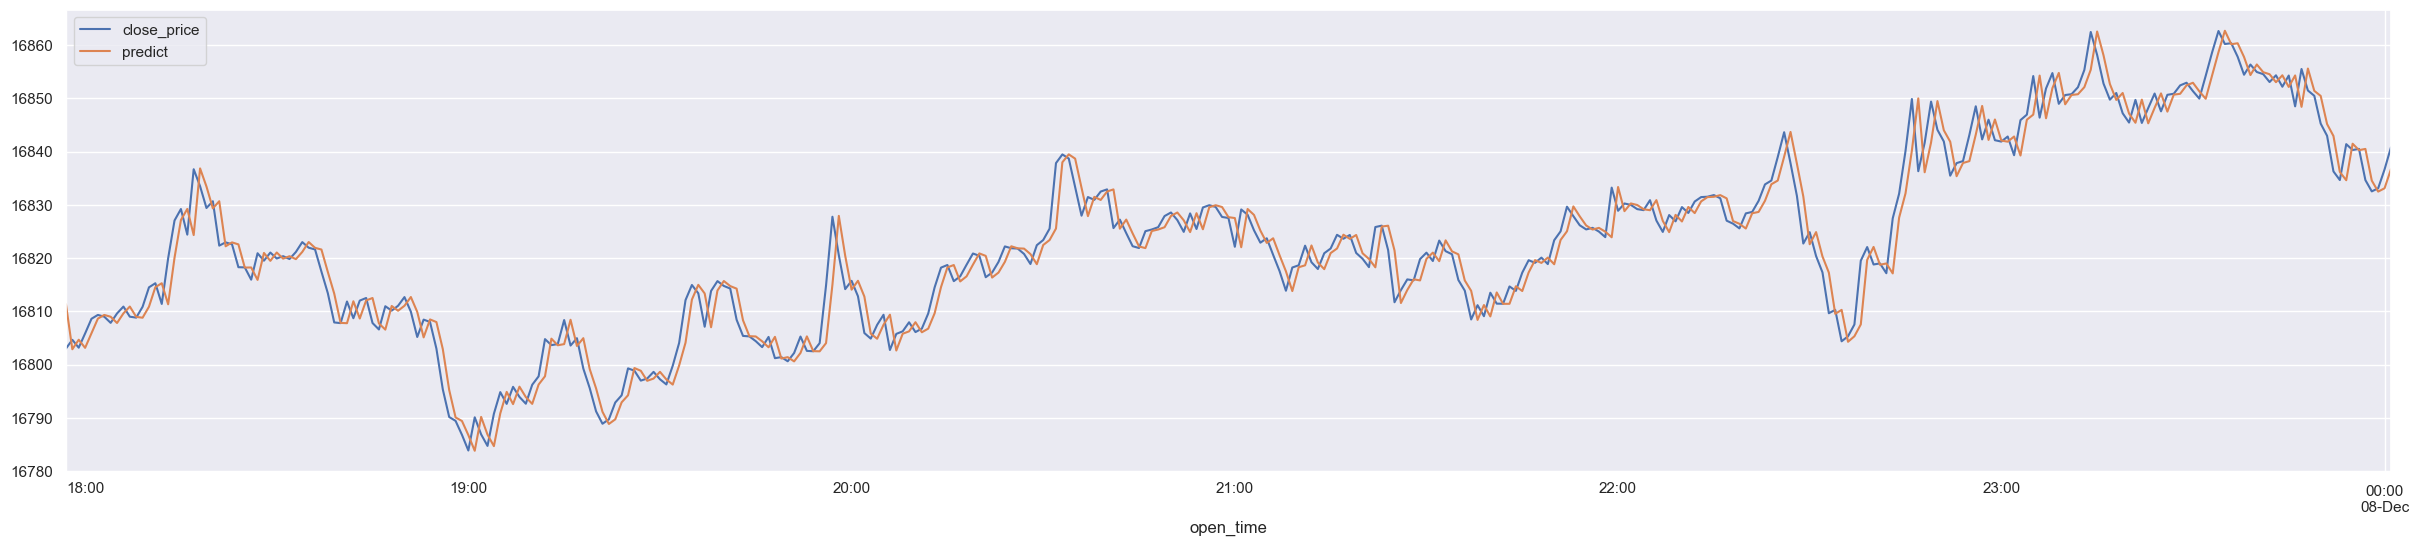

In [12]:
btc_close[['close_price', 'predict']][-365:].plot();

In [13]:
data = btc_close[['close_price']].copy()
data['time'] = np.arange(1, len(data) + 1)
data = round(data, 2)
reg = np.polyfit(data['time'], data['close_price'], deg=1)
reg

array([1.54313327e-02, 4.12309048e+02])

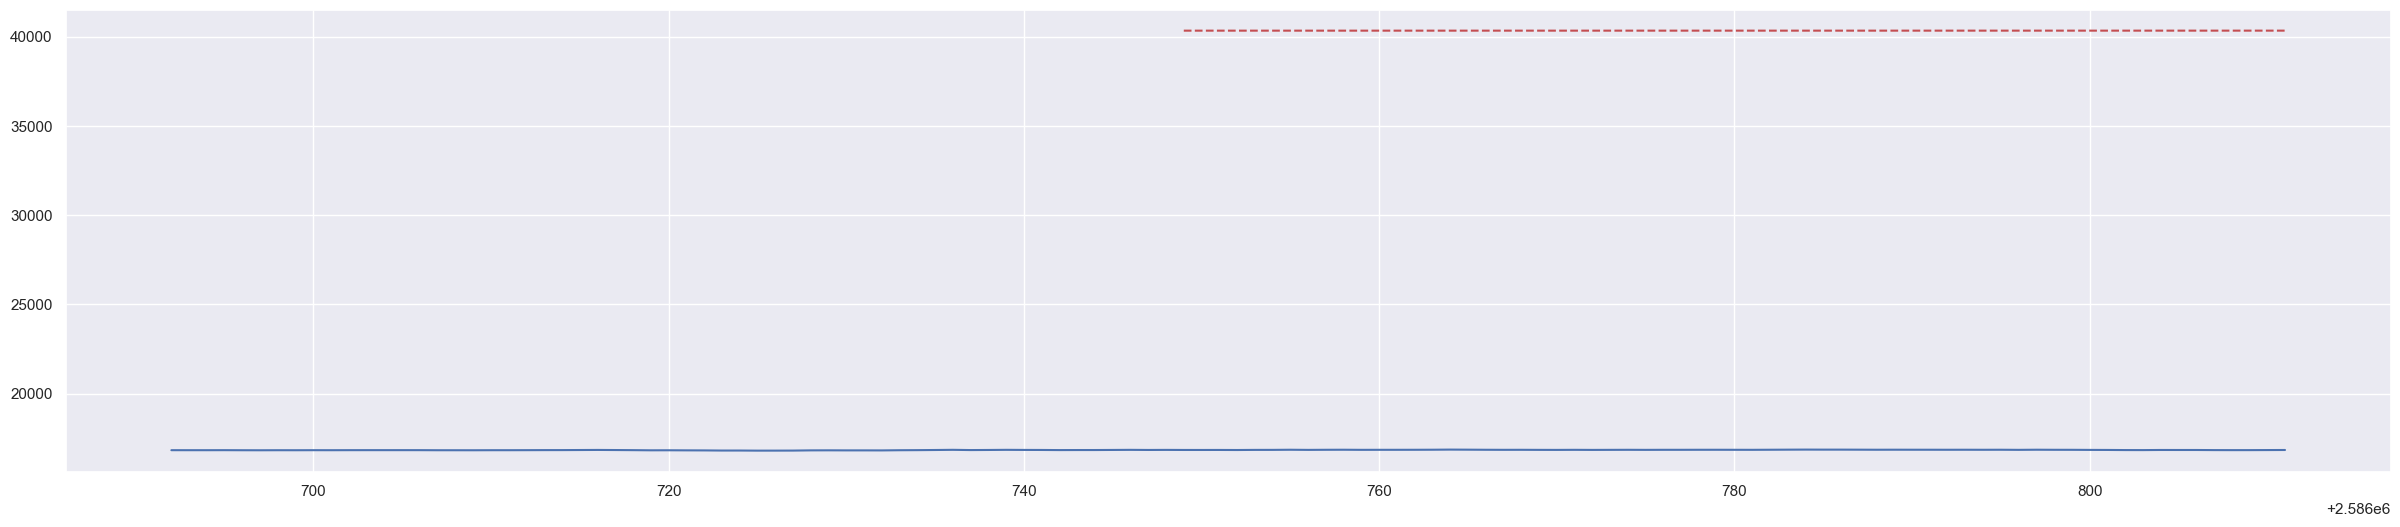

In [14]:
trend = np.polyval(reg, data['time'][-63:])
std = data['close_price'][-63:].std()
plt.plot(data['time'][-120:], data['close_price'][-120:], label='BTCUSD')
plt.plot(data['time'][-63:], trend, 'r--');

In [15]:
new_df = df[-30:]

fig = go.Figure(data=[go.Candlestick(x=new_df.index,
                                     open=new_df['open_price'],
                                     high=new_df['high_price'],
                                     low=new_df['low_price'],
                                     close=new_df['close_price'],
                                     name='Candlestick')]).update_layout(xaxis_rangeslider_visible=False)

fig.update_layout(
    autosize=False,
    width=1500,
    height=800)

fig.show()